In [178]:
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import os as os
import matplotlib.pyplot as plt
import gc 
from scipy.stats.mstats import winsorize
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.linear_model import LinearRegression,Lasso, SGDRegressor, SGDClassifier, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import (RandomizedSearchCV,GridSearchCV, TimeSeriesSplit, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve)
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import preprocessing
from zipfile import ZipFile
from sklearn import metrics, tree
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tools.eval_measures import mse, rmse
import itertools
import warnings
from sklearn.compose import TransformedTargetRegressor
import time
import plotly.express as px
from scipy.stats import poisson

In [2]:
def reduce_memory_usage(df, verbose=True): ## As 
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
df_Ire = pd.concat([pd.read_csv('1991-2004.csv'),pd.read_csv('2005-2014.csv'),pd.read_csv('2015-2021.csv')])

In [4]:
df_Ire.head()

,Statistic Label,Region,Type of Animal,Year,UNIT,VALUE,STATISTIC Label
0,Number of Livestock in June (1991 - 2004),Border,Total cattle,1991,000 Head,916.5,NaN
1,Number of Livestock in June (1991 - 2004),Border,Total cattle,1992,000 Head,924.3,NaN
2,Number of Livestock in June (1991 - 2004),Border,Total cattle,1993,000 Head,928.4,NaN
3,Number of Livestock in June (1991 - 2004),Border,Total cattle,1994,000 Head,934.0,NaN
4,Number of Livestock in June (1991 - 2004),Border,Total cattle,1995,000 Head,933.6,NaN


In [5]:
df_Ire.tail()

,Statistic Label,Region,Type of Animal,Year,UNIT,VALUE,STATISTIC Label
289,NaN,Mid-West,Total goats,2021,000 Head,1.9,Number of Livestock in June
290,NaN,South-East,Total goats,2021,000 Head,0.7,Number of Livestock in June
291,NaN,South-West,Total goats,2021,000 Head,1.3,Number of Livestock in June
292,NaN,Dublin and Mid-East,Total goats,2021,000 Head,1.4,Number of Livestock in June
293,NaN,Midland,Total goats,2021,000 Head,0.8,Number of Livestock in June


In [6]:
df_Ire = df_Ire.drop(["Statistic Label", "STATISTIC Label","UNIT"], axis=1) #drop columns

In [7]:
df_Ire.head()

,Region,Type of Animal,Year,VALUE
0,Border,Total cattle,1991,916.5
1,Border,Total cattle,1992,924.3
2,Border,Total cattle,1993,928.4
3,Border,Total cattle,1994,934.0
4,Border,Total cattle,1995,933.6


In [8]:
df_Ire.tail()

,Region,Type of Animal,Year,VALUE
289,Mid-West,Total goats,2021,1.9
290,South-East,Total goats,2021,0.7
291,South-West,Total goats,2021,1.3
292,Dublin and Mid-East,Total goats,2021,1.4
293,Midland,Total goats,2021,0.8


In [9]:
df_Ire.rename(columns = {'VALUE':'Quantity'}, inplace = True)

In [10]:
df_Ire.head()

,Region,Type of Animal,Year,Quantity
0,Border,Total cattle,1991,916.5
1,Border,Total cattle,1992,924.3
2,Border,Total cattle,1993,928.4
3,Border,Total cattle,1994,934.0
4,Border,Total cattle,1995,933.6


In [11]:
df_Ire.duplicated().sum()

0

In [12]:
df_Ire.Region.unique()

array(['Border', 'Midland', 'West', 'Dublin plus Mid East', 'Mid-West',
       'South-East', 'South-West', 'Dublin and Mid-East'], dtype=object)

In [13]:
df_Ire['Region'] = df_Ire['Region'].str.replace('Dublin and Mid-East', 'Dublin plus Mid East',regex = True)

In [14]:
df_Ire.Region.unique()

array(['Border', 'Midland', 'West', 'Dublin plus Mid East', 'Mid-West',
       'South-East', 'South-West'], dtype=object)

In [15]:
df_Ire.Year.unique()

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [16]:
df_Ire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 293
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          1302 non-null   object 
 1   Type of Animal  1302 non-null   object 
 2   Year            1302 non-null   int64  
 3   Quantity        1302 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 50.9+ KB


In [17]:
df_Ire.isnull().sum()

Region            0
Type of Animal    0
Year              0
Quantity          0
dtype: int64

In [18]:
df_Ire.shape

(1302, 4)

In [19]:
df_Ire.Quantity.describe()

count    1302.000000
mean      362.713210
std       497.233292
min         0.300000
25%         1.800000
50%        26.900000
75%       699.975000
max      2192.700000
Name: Quantity, dtype: float64

In [20]:
df_Ire.count()

Region            1302
Type of Animal    1302
Year              1302
Quantity          1302
dtype: int64

In [21]:
df_Ire.Quantity.skew(axis = 0)

1.2651456127634129

C:\Users\krist\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


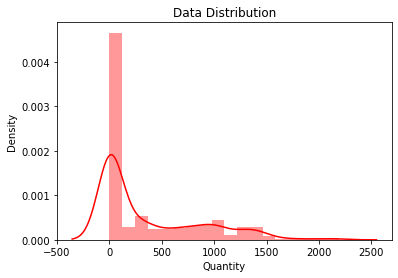

In [22]:
sns.distplot(df_Ire.Quantity, hist=True, color="r", label="Fitted Values")


plt.title('Data Distribution')

plt.show()
plt.close()
sns.set_style("darkgrid")

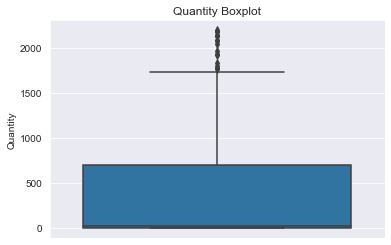

In [23]:
sns.boxplot(y=df_Ire.Quantity); #boxplot graph showing the quantity of outliers present in our data
plt.title('Quantity Boxplot')
sns.set_style("darkgrid")

In [24]:
df_Ire.groupby(['Year'],sort = False)['Quantity'].sum().reset_index()

,Year,Quantity
0,1991,17191.9
1,1992,17326.2
2,1993,17222.3
3,1994,17022.3
4,1995,17006.5
5,1996,16915.1
6,1997,17458.1
7,1998,17865.9
8,1999,17195.8
9,2000,16397.9


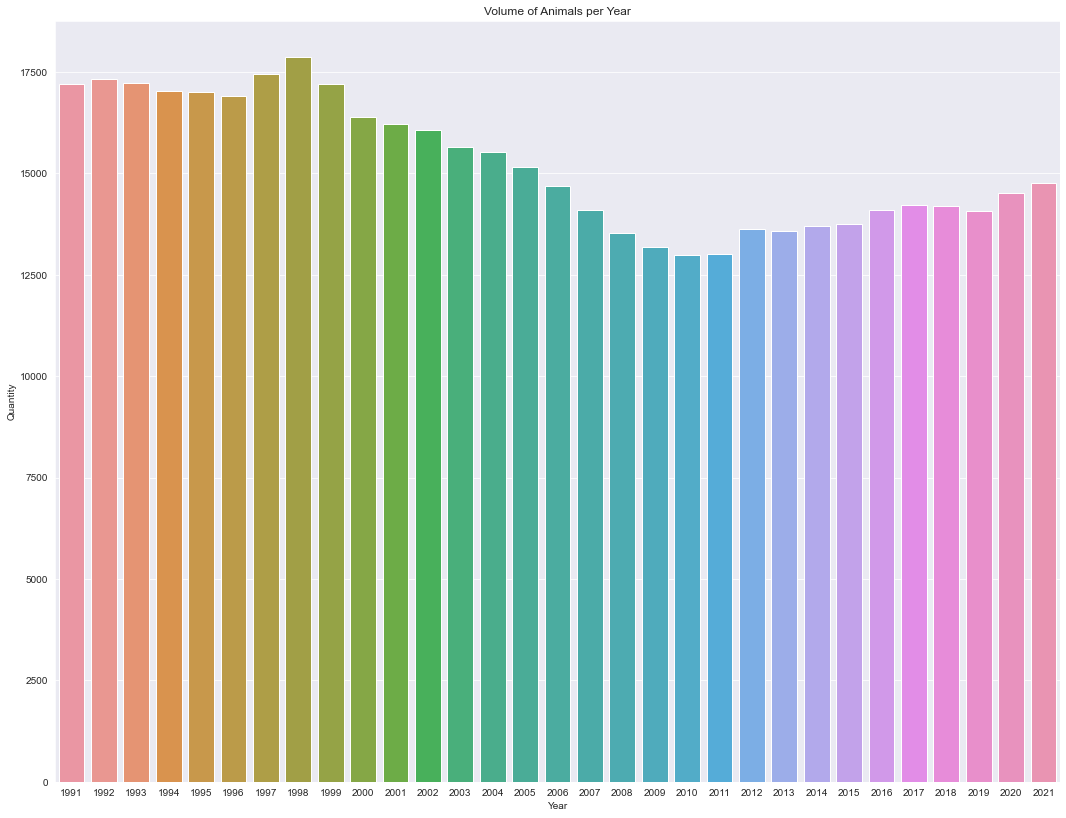

In [25]:
plt.figure(figsize=(18,14))
ax = sns.barplot(x = 'Year', y = 'Quantity', ci = None, data = df_Ire, estimator=sum)
plt.title('Volume of Animals per Year')
sns.set_style("darkgrid")

In [26]:
df_Ire_mean_temps = pd.read_csv('ireland_mean_temps_1901-2021.csv',skiprows=1)

In [27]:
df_Ire_mean_temps.head()

,Unnamed: 0,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
0,1901,8.84,8.85,8.36,9.33,9.31,8.03,8.74,8.91,9.29,...,8.42,8.42,8.70,8.58,8.26,8.84,9.08,8.60,9.26,8.78
1,1902,8.86,8.89,8.33,9.39,9.40,7.91,8.72,8.93,9.36,...,8.30,8.30,8.72,8.59,8.26,8.91,9.13,8.60,9.30,8.80
2,1903,8.82,8.88,8.28,9.33,9.35,7.89,8.68,8.86,9.31,...,8.29,8.29,8.67,8.52,8.19,8.87,9.12,8.54,9.31,8.78
3,1904,8.80,8.87,8.27,9.30,9.32,7.91,8.68,8.84,9.29,...,8.29,8.29,8.65,8.51,8.18,8.85,9.09,8.53,9.28,8.76
4,1905,9.01,9.04,8.53,9.49,9.49,8.16,8.93,9.08,9.46,...,8.56,8.56,8.88,8.76,8.43,9.03,9.27,8.78,9.45,8.96


In [28]:
df_Ire_mean_temps.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)

In [29]:
df_Ire_mean_temps.head()

,Year,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
0,1901,8.84,8.85,8.36,9.33,9.31,8.03,8.74,8.91,9.29,...,8.42,8.42,8.70,8.58,8.26,8.84,9.08,8.60,9.26,8.78
1,1902,8.86,8.89,8.33,9.39,9.40,7.91,8.72,8.93,9.36,...,8.30,8.30,8.72,8.59,8.26,8.91,9.13,8.60,9.30,8.80
2,1903,8.82,8.88,8.28,9.33,9.35,7.89,8.68,8.86,9.31,...,8.29,8.29,8.67,8.52,8.19,8.87,9.12,8.54,9.31,8.78
3,1904,8.80,8.87,8.27,9.30,9.32,7.91,8.68,8.84,9.29,...,8.29,8.29,8.65,8.51,8.18,8.85,9.09,8.53,9.28,8.76
4,1905,9.01,9.04,8.53,9.49,9.49,8.16,8.93,9.08,9.46,...,8.56,8.56,8.88,8.76,8.43,9.03,9.27,8.78,9.45,8.96


In [30]:
df_Ire_mean_temps.tail()

,Year,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
116,2017,10.00,10.03,9.53,10.48,10.48,9.18,9.97,10.06,10.44,...,9.55,9.55,9.86,9.74,9.41,10.01,10.25,9.76,10.45,9.98
117,2018,9.70,9.74,9.23,10.17,10.18,8.85,9.68,9.75,10.14,...,9.25,9.25,9.55,9.42,9.11,9.71,9.95,9.46,10.17,9.68
118,2019,9.87,9.88,9.40,10.35,10.34,9.08,9.83,9.93,10.32,...,9.44,9.44,9.72,9.61,9.29,9.87,10.11,9.63,10.31,9.84
119,2020,9.79,9.82,9.31,10.26,10.26,8.97,9.77,9.84,10.23,...,9.34,9.34,9.64,9.51,9.18,9.79,10.04,9.54,10.27,9.78
120,2021,9.95,9.96,9.47,10.43,10.43,9.12,9.89,10.02,10.40,...,9.49,9.49,9.80,9.69,9.37,9.95,10.19,9.70,10.38,9.90


In [31]:
df_Ire_mean_temps = df_Ire_mean_temps[df_Ire_mean_temps['Year'] >= 1991]

In [32]:
df_Ire_mean_temps.head()

,Year,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
90,1991,9.51,9.53,9.04,10.01,9.98,8.66,9.39,9.59,9.96,...,9.04,9.04,9.39,9.27,8.96,9.53,9.74,9.28,9.88,9.43
91,1992,9.45,9.48,8.98,9.93,9.93,8.61,9.36,9.51,9.91,...,9.00,9.00,9.32,9.18,8.87,9.47,9.71,9.21,9.89,9.41
92,1993,9.28,9.32,8.75,9.80,9.80,8.36,9.11,9.37,9.78,...,8.75,8.75,9.15,9.02,8.70,9.31,9.54,9.02,9.70,9.18
93,1994,9.49,9.52,8.97,9.98,10.03,8.59,9.37,9.55,9.97,...,8.97,8.97,9.35,9.21,8.89,9.52,9.77,9.24,9.98,9.45
94,1995,10.02,10.07,9.48,10.52,10.54,9.05,9.94,10.09,10.51,...,9.45,9.45,9.89,9.74,9.38,10.07,10.33,9.77,10.54,10.03


In [33]:
df_Ire_mean_temps.tail()

,Year,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
116,2017,10.00,10.03,9.53,10.48,10.48,9.18,9.97,10.06,10.44,...,9.55,9.55,9.86,9.74,9.41,10.01,10.25,9.76,10.45,9.98
117,2018,9.70,9.74,9.23,10.17,10.18,8.85,9.68,9.75,10.14,...,9.25,9.25,9.55,9.42,9.11,9.71,9.95,9.46,10.17,9.68
118,2019,9.87,9.88,9.40,10.35,10.34,9.08,9.83,9.93,10.32,...,9.44,9.44,9.72,9.61,9.29,9.87,10.11,9.63,10.31,9.84
119,2020,9.79,9.82,9.31,10.26,10.26,8.97,9.77,9.84,10.23,...,9.34,9.34,9.64,9.51,9.18,9.79,10.04,9.54,10.27,9.78
120,2021,9.95,9.96,9.47,10.43,10.43,9.12,9.89,10.02,10.40,...,9.49,9.49,9.80,9.69,9.37,9.95,10.19,9.70,10.38,9.90


In [34]:
df_Ire_mean_temps = df_Ire_mean_temps.drop(["Ireland"], axis=1) #drop columns

In [35]:
df_Ire_mean_temps.head()

,Year,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,Kildare,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
90,1991,9.53,9.04,10.01,9.98,8.66,9.39,9.59,9.96,9.46,...,9.04,9.04,9.39,9.27,8.96,9.53,9.74,9.28,9.88,9.43
91,1992,9.48,8.98,9.93,9.93,8.61,9.36,9.51,9.91,9.39,...,9.00,9.00,9.32,9.18,8.87,9.47,9.71,9.21,9.89,9.41
92,1993,9.32,8.75,9.80,9.80,8.36,9.11,9.37,9.78,9.19,...,8.75,8.75,9.15,9.02,8.70,9.31,9.54,9.02,9.70,9.18
93,1994,9.52,8.97,9.98,10.03,8.59,9.37,9.55,9.97,9.41,...,8.97,8.97,9.35,9.21,8.89,9.52,9.77,9.24,9.98,9.45
94,1995,10.07,9.48,10.52,10.54,9.05,9.94,10.09,10.51,9.96,...,9.45,9.45,9.89,9.74,9.38,10.07,10.33,9.77,10.54,10.03


In [36]:
df_Ire_mean_temps = df_Ire_mean_temps.melt(id_vars=["Year"], 
        var_name="County", 
        value_name="Mean_Temperature")

In [37]:
df_Ire_mean_temps.head()

,Year,County,Mean_Temperature
0,1991,Carlow,9.53
1,1992,Carlow,9.48
2,1993,Carlow,9.32
3,1994,Carlow,9.52
4,1995,Carlow,10.07


In [38]:
df_Ire_mean_temps.tail()

,Year,County,Mean_Temperature
832,2017,Wicklow,9.98
833,2018,Wicklow,9.68
834,2019,Wicklow,9.84
835,2020,Wicklow,9.78
836,2021,Wicklow,9.90


In [39]:
df_Regions = pd.read_excel('Nuts_regions.xlsx',usecols = ['NUTS 3 Name','County'])

In [40]:
df_Regions.head()

,NUTS 3 Name,County
0,Border,Donegal
1,Border,Sligo
2,Border,Leitrim
3,Border,Cavan
4,Border,Monaghan


In [41]:
df_Regions.tail()

,NUTS 3 Name,County
21,Mid-East,Louth
22,Midlands,Longford
23,Midlands,Westmeath
24,Midlands,Offaly
25,Midlands,Laois


In [42]:
df_Regions.rename(columns = {'NUTS 3 Name':'Region'}, inplace = True)

In [43]:
df_Regions.head()

,Region,County
0,Border,Donegal
1,Border,Sligo
2,Border,Leitrim
3,Border,Cavan
4,Border,Monaghan


In [44]:
df_Ire_mean_temps = pd.merge(df_Ire_mean_temps, df_Regions, how="inner", on=["County"])

In [45]:
df_Ire_mean_temps.head()

,Year,County,Mean_Temperature,Region
0,1991,Carlow,9.53,South East
1,1992,Carlow,9.48,South East
2,1993,Carlow,9.32,South East
3,1994,Carlow,9.52,South East
4,1995,Carlow,10.07,South East


In [46]:
df_Ire_mean_temps.tail()

,Year,County,Mean_Temperature,Region
801,2017,Wicklow,9.98,Mid-East
802,2018,Wicklow,9.68,Mid-East
803,2019,Wicklow,9.84,Mid-East
804,2020,Wicklow,9.78,Mid-East
805,2021,Wicklow,9.90,Mid-East


In [47]:
df_Ire_mean_temps['Region'] = df_Ire_mean_temps['Region'].str.replace('Dublin', 'Dublin plus Mid East',regex = True)
df_Ire_mean_temps['Region'] = df_Ire_mean_temps['Region'].str.replace('Mid-East', 'Dublin plus Mid East',regex = True)

In [48]:
df_Ire_mean_temps = df_Ire_mean_temps.groupby(['Region','Year'],sort = False)['Mean_Temperature'].mean().reset_index()

In [49]:
df_Ire_mean_temps.head()

,Region,Year,Mean_Temperature
0,South East,1991,9.6725
1,South East,1992,9.6475
2,South East,1993,9.4775
3,South East,1994,9.7075
4,South East,1995,10.2650


In [50]:
df_Ire_mean_temps.tail()

,Region,Year,Mean_Temperature
212,Midlands,2017,9.8100
213,Midlands,2018,9.5050
214,Midlands,2019,9.6775
215,Midlands,2020,9.5875
216,Midlands,2021,9.7450


In [51]:
df_Ire_prec = pd.read_csv('ireland_precipitation_1901-2021.csv',skiprows=1)

In [52]:
df_Ire_prec.head()

,Unnamed: 0,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
0,1901,1068.52,983.20,1018.93,1055.24,1153.06,1288.02,942.31,1044.95,1323.52,...,933.47,933.47,851.14,1008.41,1206.83,1030.92,1129.96,901.61,988.85,978.16
1,1902,1016.31,965.42,939.44,1004.48,1119.44,1167.77,934.83,984.17,1277.05,...,864.39,864.39,831.83,943.86,1087.75,1002.13,1101.99,852.81,967.98,966.45
2,1903,1368.16,1282.10,1235.62,1376.31,1525.32,1564.40,1197.84,1350.96,1747.10,...,1131.68,1131.68,1116.15,1280.60,1479.39,1355.40,1484.59,1134.94,1275.17,1256.88
3,1904,1081.95,970.03,985.97,1114.46,1235.12,1282.28,902.41,1069.77,1421.42,...,906.37,906.37,840.18,1003.16,1173.82,1041.08,1144.26,873.39,974.31,950.28
4,1905,957.80,850.82,898.77,963.50,1064.98,1181.87,815.87,946.80,1230.65,...,821.47,821.47,745.23,898.72,1071.46,910.80,1000.54,783.38,861.72,851.38


In [53]:
df_Ire_prec.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)

In [54]:
df_Ire_prec.head()

,Year,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
0,1901,1068.52,983.20,1018.93,1055.24,1153.06,1288.02,942.31,1044.95,1323.52,...,933.47,933.47,851.14,1008.41,1206.83,1030.92,1129.96,901.61,988.85,978.16
1,1902,1016.31,965.42,939.44,1004.48,1119.44,1167.77,934.83,984.17,1277.05,...,864.39,864.39,831.83,943.86,1087.75,1002.13,1101.99,852.81,967.98,966.45
2,1903,1368.16,1282.10,1235.62,1376.31,1525.32,1564.40,1197.84,1350.96,1747.10,...,1131.68,1131.68,1116.15,1280.60,1479.39,1355.40,1484.59,1134.94,1275.17,1256.88
3,1904,1081.95,970.03,985.97,1114.46,1235.12,1282.28,902.41,1069.77,1421.42,...,906.37,906.37,840.18,1003.16,1173.82,1041.08,1144.26,873.39,974.31,950.28
4,1905,957.80,850.82,898.77,963.50,1064.98,1181.87,815.87,946.80,1230.65,...,821.47,821.47,745.23,898.72,1071.46,910.80,1000.54,783.38,861.72,851.38


In [55]:
df_Ire_prec.tail()

,Year,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
116,2017,1174.26,1062.72,1119.19,1153.20,1273.88,1479.77,1018.30,1151.08,1465.66,...,1024.69,1024.69,923.08,1104.78,1349.56,1111.37,1225.02,976.72,1074.69,1058.49
117,2018,1206.47,1076.11,1119.95,1205.06,1350.70,1464.49,1018.71,1182.57,1569.17,...,1016.81,1016.81,932.81,1115.87,1361.69,1155.06,1263.93,982.17,1108.28,1073.62
118,2019,1289.40,1150.00,1224.10,1284.32,1398.04,1571.72,1102.75,1281.50,1616.96,...,1120.99,1120.99,1020.94,1222.75,1483.84,1229.87,1335.88,1075.76,1169.89,1147.99
119,2020,1351.05,1212.33,1266.13,1337.43,1493.93,1684.96,1149.55,1322.36,1725.47,...,1159.82,1159.82,1050.53,1257.39,1538.96,1287.01,1421.91,1103.99,1239.32,1203.76
120,2021,1147.14,1068.08,1079.62,1121.59,1270.53,1383.32,997.33,1110.63,1454.64,...,986.83,986.83,905.47,1062.87,1288.10,1104.29,1226.74,948.43,1089.05,1054.35


In [56]:
df_Ire_prec = df_Ire_prec[df_Ire_prec['Year'] >= 1991]

In [57]:
df_Ire_prec.head()

,Year,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
90,1991,1070.58,971.41,998.31,1058.94,1152.03,1357.46,894.17,1063.22,1337.35,...,879.12,879.12,845.49,1019.66,1255.82,1009.88,1102.16,883.78,989.58,958.22
91,1992,1129.81,919.76,1096.77,1128.06,1172.19,1564.67,882.89,1170.42,1382.13,...,996.74,996.74,855.43,1122.93,1431.71,1017.57,1082.40,920.07,937.17,911.00
92,1993,1229.93,1180.35,1165.81,1204.21,1335.58,1473.89,1109.07,1171.49,1511.19,...,1063.93,1063.93,1000.95,1139.63,1366.33,1198.42,1321.46,1047.61,1194.10,1169.39
93,1994,1309.49,1203.84,1153.12,1332.03,1494.87,1522.62,1085.57,1280.40,1713.78,...,1019.94,1019.94,1030.63,1191.71,1449.58,1291.33,1430.50,1051.15,1246.21,1170.08
94,1995,1155.17,1044.02,1097.47,1141.69,1255.03,1419.07,971.23,1135.98,1468.34,...,996.60,996.60,913.06,1088.36,1331.32,1093.12,1194.47,966.30,1059.92,1022.80


In [58]:
df_Ire_prec.tail()

,Year,Ireland,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
116,2017,1174.26,1062.72,1119.19,1153.20,1273.88,1479.77,1018.30,1151.08,1465.66,...,1024.69,1024.69,923.08,1104.78,1349.56,1111.37,1225.02,976.72,1074.69,1058.49
117,2018,1206.47,1076.11,1119.95,1205.06,1350.70,1464.49,1018.71,1182.57,1569.17,...,1016.81,1016.81,932.81,1115.87,1361.69,1155.06,1263.93,982.17,1108.28,1073.62
118,2019,1289.40,1150.00,1224.10,1284.32,1398.04,1571.72,1102.75,1281.50,1616.96,...,1120.99,1120.99,1020.94,1222.75,1483.84,1229.87,1335.88,1075.76,1169.89,1147.99
119,2020,1351.05,1212.33,1266.13,1337.43,1493.93,1684.96,1149.55,1322.36,1725.47,...,1159.82,1159.82,1050.53,1257.39,1538.96,1287.01,1421.91,1103.99,1239.32,1203.76
120,2021,1147.14,1068.08,1079.62,1121.59,1270.53,1383.32,997.33,1110.63,1454.64,...,986.83,986.83,905.47,1062.87,1288.10,1104.29,1226.74,948.43,1089.05,1054.35


In [59]:
df_Ire_prec = df_Ire_prec.drop(["Ireland"], axis=1) #drop columns

In [60]:
df_Ire_prec.head()

,Year,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,Kildare,...,Monaghan,Munster,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
90,1991,971.41,998.31,1058.94,1152.03,1357.46,894.17,1063.22,1337.35,845.91,...,879.12,879.12,845.49,1019.66,1255.82,1009.88,1102.16,883.78,989.58,958.22
91,1992,919.76,1096.77,1128.06,1172.19,1564.67,882.89,1170.42,1382.13,833.95,...,996.74,996.74,855.43,1122.93,1431.71,1017.57,1082.40,920.07,937.17,911.00
92,1993,1180.35,1165.81,1204.21,1335.58,1473.89,1109.07,1171.49,1511.19,1022.00,...,1063.93,1063.93,1000.95,1139.63,1366.33,1198.42,1321.46,1047.61,1194.10,1169.39
93,1994,1203.84,1153.12,1332.03,1494.87,1522.62,1085.57,1280.40,1713.78,1021.11,...,1019.94,1019.94,1030.63,1191.71,1449.58,1291.33,1430.50,1051.15,1246.21,1170.08
94,1995,1044.02,1097.47,1141.69,1255.03,1419.07,971.23,1135.98,1468.34,908.18,...,996.60,996.60,913.06,1088.36,1331.32,1093.12,1194.47,966.30,1059.92,1022.80


In [61]:
df_Ire_prec = df_Ire_prec.melt(id_vars=["Year"], 
        var_name="County", 
        value_name="Precipitation")

In [62]:
df_Ire_prec.head()

,Year,County,Precipitation
0,1991,Carlow,971.41
1,1992,Carlow,919.76
2,1993,Carlow,1180.35
3,1994,Carlow,1203.84
4,1995,Carlow,1044.02


In [63]:
df_Ire_prec.tail()

,Year,County,Precipitation
832,2017,Wicklow,1058.49
833,2018,Wicklow,1073.62
834,2019,Wicklow,1147.99
835,2020,Wicklow,1203.76
836,2021,Wicklow,1054.35


In [64]:
df_Ire_prec = pd.merge(df_Ire_prec, df_Regions, how="inner", on=["County"])

In [65]:
df_Ire_prec.head()

,Year,County,Precipitation,Region
0,1991,Carlow,971.41,South East
1,1992,Carlow,919.76,South East
2,1993,Carlow,1180.35,South East
3,1994,Carlow,1203.84,South East
4,1995,Carlow,1044.02,South East


In [66]:
df_Ire_prec.tail()

,Year,County,Precipitation,Region
801,2017,Wicklow,1058.49,Mid-East
802,2018,Wicklow,1073.62,Mid-East
803,2019,Wicklow,1147.99,Mid-East
804,2020,Wicklow,1203.76,Mid-East
805,2021,Wicklow,1054.35,Mid-East


In [67]:
df_Ire_prec['Region'] = df_Ire_prec['Region'].str.replace('Dublin', 'Dublin plus Mid East',regex = True)
df_Ire_prec['Region'] = df_Ire_prec['Region'].str.replace('Mid-East', 'Dublin plus Mid East',regex = True)

In [68]:
df_Ire_prec = df_Ire_prec.groupby(['Region','Year'],sort = False)['Precipitation'].mean().reset_index()

In [69]:
df_Ire_prec.head()

,Region,Year,Precipitation
0,South East,1991,997.3375
1,South East,1992,961.9000
2,South East,1993,1205.8300
3,South East,1994,1264.9000
4,South East,1995,1074.4150


In [70]:
df_Ire_prec.tail()

,Region,Year,Precipitation
212,Midlands,2017,979.7000
213,Midlands,2018,989.0125
214,Midlands,2019,1080.8425
215,Midlands,2020,1113.9775
216,Midlands,2021,955.8850


In [71]:
df_Ire_weather = pd.merge(df_Ire_mean_temps, df_Ire_prec, how="inner", on=["Region","Year"])

In [72]:
df_Ire_weather.head()

,Region,Year,Mean_Temperature,Precipitation
0,South East,1991,9.6725,997.3375
1,South East,1992,9.6475,961.9000
2,South East,1993,9.4775,1205.8300
3,South East,1994,9.7075,1264.9000
4,South East,1995,10.2650,1074.4150


In [73]:
df_Ire_weather.tail()

,Region,Year,Mean_Temperature,Precipitation
212,Midlands,2017,9.8100,979.7000
213,Midlands,2018,9.5050,989.0125
214,Midlands,2019,9.6775,1080.8425
215,Midlands,2020,9.5875,1113.9775
216,Midlands,2021,9.7450,955.8850


In [74]:
df_Ire_weather.Region.unique()

array(['South East', 'Border', 'Mid-west', 'South-West',
       'Dublin plus Mid East', 'West', 'Midlands'], dtype=object)

In [75]:
df_Ire.Region.unique()

array(['Border', 'Midland', 'West', 'Dublin plus Mid East', 'Mid-West',
       'South-East', 'South-West'], dtype=object)

In [76]:
df_Ire_weather['Region'] = df_Ire_weather['Region'].str.replace('South East', 'South-East',regex = True)
df_Ire_weather['Region'] = df_Ire_weather['Region'].str.replace('Midlands', 'Midland',regex = True)
df_Ire_weather['Region'] = df_Ire_weather['Region'].str.replace('Mid-west', 'Mid-West',regex = True)

In [77]:
df_Ire_weather.Region.unique()

array(['South-East', 'Border', 'Mid-West', 'South-West',
       'Dublin plus Mid East', 'West', 'Midland'], dtype=object)

In [78]:
df_Ire.Region.unique()

array(['Border', 'Midland', 'West', 'Dublin plus Mid East', 'Mid-West',
       'South-East', 'South-West'], dtype=object)

In [79]:
df_Ire = pd.merge(df_Ire, df_Ire_weather, how="inner", on=["Region","Year"])

In [80]:
df_Ire.head()

,Region,Type of Animal,Year,Quantity,Mean_Temperature,Precipitation
0,Border,Total cattle,1991,916.5,8.916,1140.468
1,Border,Total sheep,1991,1402.8,8.916,1140.468
2,Border,Total pigs,1991,304.5,8.916,1140.468
3,Border,Total horses and ponies,1991,4.7,8.916,1140.468
4,Border,"Total mules, jennets and asses",1991,1.1,8.916,1140.468


In [81]:
df_Ire.tail()

,Region,Type of Animal,Year,Quantity,Mean_Temperature,Precipitation
1297,Midland,Total sheep,2021,374.3,9.745,955.885
1298,Midland,Total pigs,2021,186.4,9.745,955.885
1299,Midland,Total horses and ponies,2021,8.6,9.745,955.885
1300,Midland,"Total mules, jennets and asses",2021,0.5,9.745,955.885
1301,Midland,Total goats,2021,0.8,9.745,955.885


In [82]:
df_Ire.Year.unique()

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [83]:
df_Ire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 1301
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Region            1302 non-null   object 
 1   Type of Animal    1302 non-null   object 
 2   Year              1302 non-null   int64  
 3   Quantity          1302 non-null   float64
 4   Mean_Temperature  1302 non-null   float64
 5   Precipitation     1302 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 71.2+ KB


In [84]:
df_Ire.isnull().sum()

Region              0
Type of Animal      0
Year                0
Quantity            0
Mean_Temperature    0
Precipitation       0
dtype: int64

In [85]:
df_Ire.shape

(1302, 6)

In [86]:
df_Ire.describe()

,Year,Quantity,Mean_Temperature,Precipitation
count,1302.000000,1302.000000,1302.000000,1302.000000
mean,2006.000000,362.713210,9.737049,1170.793238
std,8.947709,497.233292,0.467058,180.559649
min,1991.000000,0.300000,8.114000,821.147500
25%,1998.000000,1.800000,9.423333,1048.102500
50%,2006.000000,26.900000,9.790000,1141.534000
75%,2014.000000,699.975000,10.072500,1292.865000
max,2021.000000,2192.700000,10.760000,1719.315000


In [87]:
df_Ire.count()

Region              1302
Type of Animal      1302
Year                1302
Quantity            1302
Mean_Temperature    1302
Precipitation       1302
dtype: int64

In [88]:
df_Ire.corr()

,Year,Quantity,Mean_Temperature,Precipitation
Year,1.000000,-0.062018,0.096218,0.112667
Quantity,-0.062018,1.000000,-0.002917,0.081604
Mean_Temperature,0.096218,-0.002917,1.000000,0.174833
Precipitation,0.112667,0.081604,0.174833,1.000000


In [89]:
encoder = OneHotEncoder(sparse = False) #use OneHotEncoder to translate regions categorical data
region_reshaped = np.array(df_Ire['Region']).reshape(-1, 1)
region_values = encoder.fit_transform(region_reshaped)

In [90]:
encoder.get_feature_names_out()

array(['x0_Border', 'x0_Dublin plus Mid East', 'x0_Mid-West',
       'x0_Midland', 'x0_South-East', 'x0_South-West', 'x0_West'],
      dtype=object)

In [91]:
region_df = pd.DataFrame(region_values, columns=['x0_Border', 'x0_Dublin plus Mid East', 'x0_Mid-West',
       'x0_Midland', 'x0_South-East', 'x0_South-West', 'x0_West'],dtype = 'int8')

In [92]:
region_df.head()

,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [93]:
region_df.tail()

,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
1297,0,0,0,1,0,0,0
1298,0,0,0,1,0,0,0
1299,0,0,0,1,0,0,0
1300,0,0,0,1,0,0,0
1301,0,0,0,1,0,0,0


In [94]:
df_Ire = df_Ire.reset_index()
df_Ire = df_Ire.join(region_df) #join encoded region database with the main database
df_Ire = df_Ire.drop(['index'], axis=1)

In [95]:
df_Ire.head()

,Region,Type of Animal,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
0,Border,Total cattle,1991,916.5,8.916,1140.468,1,0,0,0,0,0,0
1,Border,Total sheep,1991,1402.8,8.916,1140.468,1,0,0,0,0,0,0
2,Border,Total pigs,1991,304.5,8.916,1140.468,1,0,0,0,0,0,0
3,Border,Total horses and ponies,1991,4.7,8.916,1140.468,1,0,0,0,0,0,0
4,Border,"Total mules, jennets and asses",1991,1.1,8.916,1140.468,1,0,0,0,0,0,0


In [96]:
df_Ire.corr()

,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
Year,1.000000e+00,-0.062018,0.096218,0.112667,-1.402540e-16,-2.610010e-15,-5.203782e-15,1.348836e-14,-7.615671e-15,-1.211012e-14,1.305038e-14
Quantity,-6.201793e-02,1.000000,-0.002917,0.081604,5.263449e-02,-6.209250e-02,-9.338304e-02,-9.010513e-02,5.615616e-02,5.759485e-02,7.919517e-02
Mean_Temperature,9.621773e-02,-0.002917,1.000000,0.174833,-5.236512e-01,-2.861677e-02,2.374513e-01,-1.665212e-01,1.695663e-01,4.132755e-01,-1.015039e-01
Precipitation,1.126675e-01,0.081604,0.174833,1.000000,2.347620e-01,-4.032590e-01,1.706577e-02,-3.726456e-01,-1.075023e-01,5.418674e-01,8.971168e-02
x0_Border,-1.402540e-16,0.052634,-0.523651,0.234762,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Dublin plus Mid East,-2.610010e-15,-0.062092,-0.028617,-0.403259,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Mid-West,-5.203782e-15,-0.093383,0.237451,0.017066,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Midland,1.348836e-14,-0.090105,-0.166521,-0.372646,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_South-East,-7.615671e-15,0.056156,0.169566,-0.107502,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01
x0_South-West,-1.211012e-14,0.057595,0.413276,0.541867,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01


In [97]:
df_Ire_cattle = df_Ire[df_Ire['Type of Animal'] == 'Total cattle']

In [98]:
df_Ire_cattle.head()

,Region,Type of Animal,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
0,Border,Total cattle,1991,916.5,8.916,1140.468,1,0,0,0,0,0,0
6,Border,Total cattle,1992,924.3,8.852,1290.936,1,0,0,0,0,0,0
12,Border,Total cattle,1993,928.4,8.630,1284.264,1,0,0,0,0,0,0
18,Border,Total cattle,1994,934.0,8.844,1309.282,1,0,0,0,0,0,0
24,Border,Total cattle,1995,933.6,9.332,1226.630,1,0,0,0,0,0,0


In [99]:
df_Ire_cattle.corr()

,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
Year,1.000000e+00,0.001473,0.096218,0.112667,5.698431e-15,-2.871120e-15,-4.338392e-15,4.435818e-15,-4.556783e-15,-3.371980e-15,5.039335e-15
Quantity,1.472896e-03,1.000000,0.479493,0.554708,-1.577815e-01,-5.987704e-01,1.731901e-01,-3.309975e-01,3.225897e-01,6.351045e-01,-4.333488e-02
Mean_Temperature,9.621773e-02,0.479493,1.000000,0.174833,-5.236512e-01,-2.861677e-02,2.374513e-01,-1.665212e-01,1.695663e-01,4.132755e-01,-1.015039e-01
Precipitation,1.126675e-01,0.554708,0.174833,1.000000,2.347620e-01,-4.032590e-01,1.706577e-02,-3.726456e-01,-1.075023e-01,5.418674e-01,8.971168e-02
x0_Border,5.698431e-15,-0.157782,-0.523651,0.234762,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Dublin plus Mid East,-2.871120e-15,-0.598770,-0.028617,-0.403259,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Mid-West,-4.338392e-15,0.173190,0.237451,0.017066,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Midland,4.435818e-15,-0.330998,-0.166521,-0.372646,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_South-East,-4.556783e-15,0.322590,0.169566,-0.107502,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01
x0_South-West,-3.371980e-15,0.635104,0.413276,0.541867,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01


In [100]:
df_Ire_sheep = df_Ire[df_Ire['Type of Animal'] == 'Total sheep']

In [101]:
df_Ire_sheep.head()

,Region,Type of Animal,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
1,Border,Total sheep,1991,1402.8,8.916,1140.468,1,0,0,0,0,0,0
7,Border,Total sheep,1992,1407.1,8.852,1290.936,1,0,0,0,0,0,0
13,Border,Total sheep,1993,1377.5,8.630,1284.264,1,0,0,0,0,0,0
19,Border,Total sheep,1994,1330.8,8.844,1309.282,1,0,0,0,0,0,0
25,Border,Total sheep,1995,1336.3,9.332,1226.630,1,0,0,0,0,0,0


In [102]:
df_Ire_sheep.corr()

,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
Year,1.000000e+00,-0.368251,0.096218,0.112667,5.698431e-15,-2.871120e-15,-4.338392e-15,4.435818e-15,-4.556783e-15,-3.371980e-15,5.039335e-15
Quantity,-3.682509e-01,1.000000,-0.230500,0.106457,2.191394e-01,5.303395e-02,-5.537563e-01,-3.719390e-01,9.989975e-02,-7.007337e-02,6.236956e-01
Mean_Temperature,9.621773e-02,-0.230500,1.000000,0.174833,-5.236512e-01,-2.861677e-02,2.374513e-01,-1.665212e-01,1.695663e-01,4.132755e-01,-1.015039e-01
Precipitation,1.126675e-01,0.106457,0.174833,1.000000,2.347620e-01,-4.032590e-01,1.706577e-02,-3.726456e-01,-1.075023e-01,5.418674e-01,8.971168e-02
x0_Border,5.698431e-15,0.219139,-0.523651,0.234762,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Dublin plus Mid East,-2.871120e-15,0.053034,-0.028617,-0.403259,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Mid-West,-4.338392e-15,-0.553756,0.237451,0.017066,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Midland,4.435818e-15,-0.371939,-0.166521,-0.372646,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_South-East,-4.556783e-15,0.099900,0.169566,-0.107502,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01
x0_South-West,-3.371980e-15,-0.070073,0.413276,0.541867,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01


In [103]:
df_Ire_goats = df_Ire[df_Ire['Type of Animal'] == 'Total goats']

In [104]:
df_Ire_goats.head()

,Region,Type of Animal,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
5,Border,Total goats,1991,3.9,8.916,1140.468,1,0,0,0,0,0,0
11,Border,Total goats,1992,3.9,8.852,1290.936,1,0,0,0,0,0,0
17,Border,Total goats,1993,4.1,8.630,1284.264,1,0,0,0,0,0,0
23,Border,Total goats,1994,3.5,8.844,1309.282,1,0,0,0,0,0,0
29,Border,Total goats,1995,3.2,9.332,1226.630,1,0,0,0,0,0,0


In [105]:
df_Ire_goats.corr()

,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
Year,1.000000e+00,-0.459820,0.096218,0.112667,5.698431e-15,-2.871120e-15,-4.338392e-15,4.435818e-15,-4.556783e-15,-3.371980e-15,5.039335e-15
Quantity,-4.598202e-01,1.000000,-0.290574,0.220912,2.807945e-01,-1.283930e-01,3.053249e-02,-1.484871e-01,-2.763582e-01,6.524036e-02,1.766709e-01
Mean_Temperature,9.621773e-02,-0.290574,1.000000,0.174833,-5.236512e-01,-2.861677e-02,2.374513e-01,-1.665212e-01,1.695663e-01,4.132755e-01,-1.015039e-01
Precipitation,1.126675e-01,0.220912,0.174833,1.000000,2.347620e-01,-4.032590e-01,1.706577e-02,-3.726456e-01,-1.075023e-01,5.418674e-01,8.971168e-02
x0_Border,5.698431e-15,0.280795,-0.523651,0.234762,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Dublin plus Mid East,-2.871120e-15,-0.128393,-0.028617,-0.403259,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Mid-West,-4.338392e-15,0.030532,0.237451,0.017066,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Midland,4.435818e-15,-0.148487,-0.166521,-0.372646,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_South-East,-4.556783e-15,-0.276358,0.169566,-0.107502,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01
x0_South-West,-3.371980e-15,0.065240,0.413276,0.541867,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01


In [106]:
df_Ire_horse = df_Ire[df_Ire['Type of Animal'] == 'Total horses and ponies']

In [107]:
df_Ire_horse.head()

,Region,Type of Animal,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
3,Border,Total horses and ponies,1991,4.7,8.916,1140.468,1,0,0,0,0,0,0
9,Border,Total horses and ponies,1992,5.4,8.852,1290.936,1,0,0,0,0,0,0
15,Border,Total horses and ponies,1993,5.9,8.630,1284.264,1,0,0,0,0,0,0
21,Border,Total horses and ponies,1994,6.0,8.844,1309.282,1,0,0,0,0,0,0
27,Border,Total horses and ponies,1995,6.7,9.332,1226.630,1,0,0,0,0,0,0


In [108]:
df_Ire_horse.corr()

,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
Year,1.000000e+00,0.346830,0.096218,0.112667,5.698431e-15,-2.871120e-15,-4.338392e-15,4.435818e-15,-4.556783e-15,-3.371980e-15,5.039335e-15
Quantity,3.468299e-01,1.000000,0.187114,-0.011542,-3.405792e-01,2.453661e-01,1.197828e-02,-4.821965e-01,4.166932e-01,-7.517077e-02,2.239089e-01
Mean_Temperature,9.621773e-02,0.187114,1.000000,0.174833,-5.236512e-01,-2.861677e-02,2.374513e-01,-1.665212e-01,1.695663e-01,4.132755e-01,-1.015039e-01
Precipitation,1.126675e-01,-0.011542,0.174833,1.000000,2.347620e-01,-4.032590e-01,1.706577e-02,-3.726456e-01,-1.075023e-01,5.418674e-01,8.971168e-02
x0_Border,5.698431e-15,-0.340579,-0.523651,0.234762,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Dublin plus Mid East,-2.871120e-15,0.245366,-0.028617,-0.403259,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Mid-West,-4.338392e-15,0.011978,0.237451,0.017066,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Midland,4.435818e-15,-0.482196,-0.166521,-0.372646,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_South-East,-4.556783e-15,0.416693,0.169566,-0.107502,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01
x0_South-West,-3.371980e-15,-0.075171,0.413276,0.541867,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01


In [109]:
df_Ire_mules = df_Ire[df_Ire['Type of Animal'] == 'Total mules, jennets and asses']

In [110]:
df_Ire_mules.head()

,Region,Type of Animal,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
4,Border,"Total mules, jennets and asses",1991,1.1,8.916,1140.468,1,0,0,0,0,0,0
10,Border,"Total mules, jennets and asses",1992,1.2,8.852,1290.936,1,0,0,0,0,0,0
16,Border,"Total mules, jennets and asses",1993,1.3,8.630,1284.264,1,0,0,0,0,0,0
22,Border,"Total mules, jennets and asses",1994,1.2,8.844,1309.282,1,0,0,0,0,0,0
28,Border,"Total mules, jennets and asses",1995,0.8,9.332,1226.630,1,0,0,0,0,0,0


In [111]:
df_Ire_mules.corr()

,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
Year,1.000000e+00,0.173101,0.096218,0.112667,5.698431e-15,-2.871120e-15,-4.338392e-15,4.435818e-15,-4.556783e-15,-3.371980e-15,5.039335e-15
Quantity,1.731008e-01,1.000000,-0.127622,0.405550,1.701551e-01,-3.515886e-01,5.173305e-02,-3.069658e-01,-3.069658e-01,3.800295e-02,7.056290e-01
Mean_Temperature,9.621773e-02,-0.127622,1.000000,0.174833,-5.236512e-01,-2.861677e-02,2.374513e-01,-1.665212e-01,1.695663e-01,4.132755e-01,-1.015039e-01
Precipitation,1.126675e-01,0.405550,0.174833,1.000000,2.347620e-01,-4.032590e-01,1.706577e-02,-3.726456e-01,-1.075023e-01,5.418674e-01,8.971168e-02
x0_Border,5.698431e-15,0.170155,-0.523651,0.234762,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Dublin plus Mid East,-2.871120e-15,-0.351589,-0.028617,-0.403259,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Mid-West,-4.338392e-15,0.051733,0.237451,0.017066,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Midland,4.435818e-15,-0.306966,-0.166521,-0.372646,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_South-East,-4.556783e-15,-0.306966,0.169566,-0.107502,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01
x0_South-West,-3.371980e-15,0.038003,0.413276,0.541867,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01


In [112]:
df_Ire_cattle

,Region,Type of Animal,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
0,Border,Total cattle,1991,916.5,8.9160,1140.468000,1,0,0,0,0,0,0
6,Border,Total cattle,1992,924.3,8.8520,1290.936000,1,0,0,0,0,0,0
12,Border,Total cattle,1993,928.4,8.6300,1284.264000,1,0,0,0,0,0,0
18,Border,Total cattle,1994,934.0,8.8440,1309.282000,1,0,0,0,0,0,0
24,Border,Total cattle,1995,933.6,9.3320,1226.630000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,Mid-West,Total cattle,2021,1472.4,10.2100,1121.786667,0,0,1,0,0,0,0
1278,South-East,Total cattle,2021,1059.5,10.1275,1102.015000,0,0,0,0,1,0,0
1284,South-West,Total cattle,2021,1464.9,10.4150,1362.585000,0,0,0,0,0,1,0
1290,Dublin plus Mid East,Total cattle,2021,719.2,9.9260,956.860000,0,1,0,0,0,0,0


In [113]:
df_Ire_cattle = pd.concat([pd.read_csv('cattle 1991-2004.csv'),pd.read_csv('cattle 2005-2014.csv'),pd.read_csv('cattle 2015-2021.csv')])

In [114]:
df_Ire_cattle.head()

,Statistic Label,Region,Type of Animal,Year,UNIT,VALUE,STATISTIC Label
0,Number of Livestock in June (1991 - 2004),Border,Dairy cows,1991,000 Head,137.0,NaN
1,Number of Livestock in June (1991 - 2004),Border,Dairy cows,1992,000 Head,132.4,NaN
2,Number of Livestock in June (1991 - 2004),Border,Dairy cows,1993,000 Head,130.9,NaN
3,Number of Livestock in June (1991 - 2004),Border,Dairy cows,1994,000 Head,129.7,NaN
4,Number of Livestock in June (1991 - 2004),Border,Dairy cows,1995,000 Head,129.5,NaN


In [115]:
df_Ire_cattle.tail()

,Statistic Label,Region,Type of Animal,Year,UNIT,VALUE,STATISTIC Label
289,NaN,Mid-West,Cattle: under 1 year,2021,000 Head,437.9,Number of Livestock in June
290,NaN,South-East,Cattle: under 1 year,2021,000 Head,304.9,Number of Livestock in June
291,NaN,South-West,Cattle: under 1 year,2021,000 Head,422.4,Number of Livestock in June
292,NaN,Dublin and Mid-East,Cattle: under 1 year,2021,000 Head,191.3,Number of Livestock in June
293,NaN,Midland,Cattle: under 1 year,2021,000 Head,255.2,Number of Livestock in June


In [116]:
df_Ire_cattle = df_Ire_cattle.drop(["Statistic Label", "STATISTIC Label","UNIT"], axis=1) #drop columns

In [117]:
df_Ire_cattle.head()

,Region,Type of Animal,Year,VALUE
0,Border,Dairy cows,1991,137.0
1,Border,Dairy cows,1992,132.4
2,Border,Dairy cows,1993,130.9
3,Border,Dairy cows,1994,129.7
4,Border,Dairy cows,1995,129.5


In [118]:
df_Ire_cattle.tail()

,Region,Type of Animal,Year,VALUE
289,Mid-West,Cattle: under 1 year,2021,437.9
290,South-East,Cattle: under 1 year,2021,304.9
291,South-West,Cattle: under 1 year,2021,422.4
292,Dublin and Mid-East,Cattle: under 1 year,2021,191.3
293,Midland,Cattle: under 1 year,2021,255.2


In [119]:
df_Ire_cattle.rename(columns = {'VALUE':'Quantity', 'Type of Animal':'Type of Cattle'}, inplace = True)

In [120]:
df_Ire_cattle.head()

,Region,Type of Cattle,Year,Quantity
0,Border,Dairy cows,1991,137.0
1,Border,Dairy cows,1992,132.4
2,Border,Dairy cows,1993,130.9
3,Border,Dairy cows,1994,129.7
4,Border,Dairy cows,1995,129.5


In [121]:
df_Ire_cattle.duplicated().sum()

0

In [122]:
df_Ire_cattle.Region.unique()

array(['Border', 'Midland', 'West', 'Dublin plus Mid East', 'Mid-West',
       'South-East', 'South-West', 'Dublin and Mid-East'], dtype=object)

In [123]:
df_Ire_cattle['Region'] = df_Ire_cattle['Region'].str.replace('Dublin and Mid-East', 'Dublin plus Mid East',regex = True)

In [124]:
df_Ire_cattle['Type of Cattle'].unique()

array(['Dairy cows', 'Other cows', 'Bulls',
       'Other cattle: 2 years and over', 'Other cattle: 1-2 years',
       'Other cattle: under 1 year', 'Cattle: 2 years and over',
       'Cattle: 1-2 years', 'Cattle: under 1 year'], dtype=object)

In [125]:
df_Ire_cattle['Type of Cattle'] = df_Ire_cattle['Type of Cattle'].str.replace('Other ca', 'Ca',regex = True)

In [126]:
df_Ire_cattle['Type of Cattle'].unique()

array(['Dairy cows', 'Other cows', 'Bulls', 'Cattle: 2 years and over',
       'Cattle: 1-2 years', 'Cattle: under 1 year'], dtype=object)

In [127]:
df_Ire_cattle.Region.unique()

array(['Border', 'Midland', 'West', 'Dublin plus Mid East', 'Mid-West',
       'South-East', 'South-West'], dtype=object)

In [128]:
df_Ire_cattle.Year.unique()

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [129]:
df_Ire_cattle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 293
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          1302 non-null   object 
 1   Type of Cattle  1302 non-null   object 
 2   Year            1302 non-null   int64  
 3   Quantity        1302 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 50.9+ KB


In [130]:
df_Ire_cattle.isnull().sum()

Region            0
Type of Cattle    0
Year              0
Quantity          0
dtype: int64

In [131]:
df_Ire_cattle.shape

(1302, 4)

In [132]:
df_Ire_cattle.Quantity.describe()

count    1302.000000
mean      164.647312
std       108.744584
min         1.700000
25%        91.650000
50%       151.500000
75%       243.000000
max       500.500000
Name: Quantity, dtype: float64

In [133]:
df_Ire_cattle.count()

Region            1302
Type of Cattle    1302
Year              1302
Quantity          1302
dtype: int64

In [134]:
df_Ire_cattle.Quantity.skew(axis = 0)

0.37221210278466577

C:\Users\krist\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


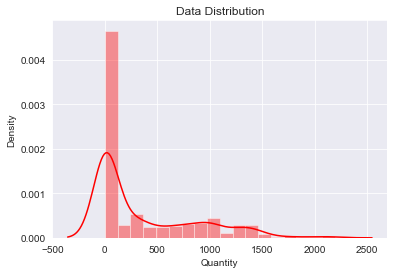

In [135]:
sns.distplot(df_Ire.Quantity, hist=True, color="r", label="Fitted Values")


plt.title('Data Distribution')

plt.show()
plt.close()
sns.set_style("darkgrid")

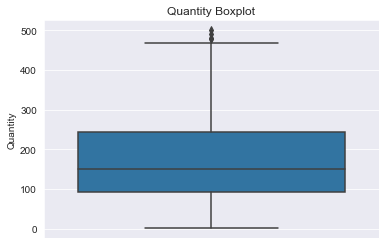

In [136]:
sns.boxplot(y=df_Ire_cattle.Quantity); #boxplot graph showing the quantity of outliers present in our data
plt.title('Quantity Boxplot')
sns.set_style("darkgrid")

In [137]:
df_Ire_cattle.groupby(['Year'],sort = False)['Quantity'].sum().reset_index()

,Year,Quantity
0,1991,6732.1
1,1992,6682.3
2,1993,6682.6
3,1994,6690.8
4,1995,6692.8
5,1996,6953.5
6,1997,7145.1
7,1998,7284.5
8,1999,7056.9
9,2000,6705.5


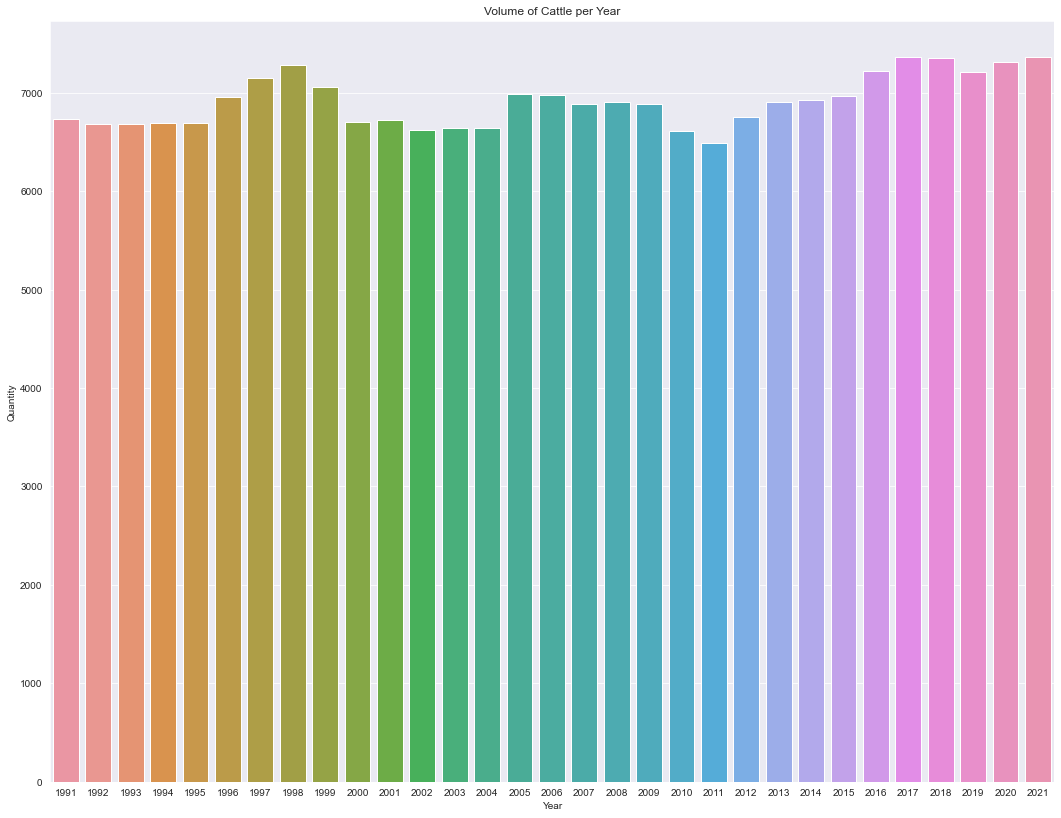

In [138]:
plt.figure(figsize=(18,14))
ax = sns.barplot(x = 'Year', y = 'Quantity', ci = None, data = df_Ire_cattle, estimator=sum)
plt.title('Volume of Cattle per Year')
sns.set_style("darkgrid")

In [139]:
df_Ire_weather.Region.unique()

array(['South-East', 'Border', 'Mid-West', 'South-West',
       'Dublin plus Mid East', 'West', 'Midland'], dtype=object)

In [140]:
df_Ire_cattle.Region.unique()

array(['Border', 'Midland', 'West', 'Dublin plus Mid East', 'Mid-West',
       'South-East', 'South-West'], dtype=object)

In [141]:
df_Ire_cattle = pd.merge(df_Ire_cattle, df_Ire_weather, how="inner", on=["Region","Year"])

In [142]:
df_Ire_cattle.head()

,Region,Type of Cattle,Year,Quantity,Mean_Temperature,Precipitation
0,Border,Dairy cows,1991,137.0,8.916,1140.468
1,Border,Other cows,1991,164.5,8.916,1140.468
2,Border,Bulls,1991,2.9,8.916,1140.468
3,Border,Cattle: 2 years and over,1991,128.8,8.916,1140.468
4,Border,Cattle: 1-2 years,1991,215.7,8.916,1140.468


In [143]:
df_Ire_cattle.tail()

,Region,Type of Cattle,Year,Quantity,Mean_Temperature,Precipitation
1297,Midland,Other cows,2021,117.8,9.745,955.885
1298,Midland,Bulls,2021,5.6,9.745,955.885
1299,Midland,Cattle: 2 years and over,2021,104.6,9.745,955.885
1300,Midland,Cattle: 1-2 years,2021,257.6,9.745,955.885
1301,Midland,Cattle: under 1 year,2021,255.2,9.745,955.885


In [144]:
df_Ire_cattle.corr()

,Year,Quantity,Mean_Temperature,Precipitation
Year,1.000000,0.029796,0.096218,0.112667
Quantity,0.029796,1.000000,0.185235,0.217688
Mean_Temperature,0.096218,0.185235,1.000000,0.174833
Precipitation,0.112667,0.217688,0.174833,1.000000


In [145]:
encoder = OneHotEncoder(sparse = False) #use OneHotEncoder to translate regions categorical data
region_reshaped = np.array(df_Ire_cattle['Region']).reshape(-1, 1)
region_values = encoder.fit_transform(region_reshaped)

In [146]:
encoder.get_feature_names_out()

array(['x0_Border', 'x0_Dublin plus Mid East', 'x0_Mid-West',
       'x0_Midland', 'x0_South-East', 'x0_South-West', 'x0_West'],
      dtype=object)

In [147]:
region_df = pd.DataFrame(region_values, columns=['x0_Border', 'x0_Dublin plus Mid East', 'x0_Mid-West',
       'x0_Midland', 'x0_South-East', 'x0_South-West', 'x0_West'],dtype = 'int8')

In [148]:
region_df.head()

,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [149]:
region_df.tail()

,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
1297,0,0,0,1,0,0,0
1298,0,0,0,1,0,0,0
1299,0,0,0,1,0,0,0
1300,0,0,0,1,0,0,0
1301,0,0,0,1,0,0,0


In [150]:
df_Ire_cattle = df_Ire_cattle.reset_index()
df_Ire_cattle = df_Ire_cattle.join(region_df) #join encoded region database with the main database
df_Ire_cattle = df_Ire_cattle.drop(['index'], axis=1)

In [151]:
df_Ire_cattle.head()

,Region,Type of Cattle,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
0,Border,Dairy cows,1991,137.0,8.916,1140.468,1,0,0,0,0,0,0
1,Border,Other cows,1991,164.5,8.916,1140.468,1,0,0,0,0,0,0
2,Border,Bulls,1991,2.9,8.916,1140.468,1,0,0,0,0,0,0
3,Border,Cattle: 2 years and over,1991,128.8,8.916,1140.468,1,0,0,0,0,0,0
4,Border,Cattle: 1-2 years,1991,215.7,8.916,1140.468,1,0,0,0,0,0,0


In [152]:
df_Ire_cattle.corr()

,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West
Year,1.000000e+00,0.029796,0.096218,0.112667,-1.402540e-16,-2.610010e-15,-5.203782e-15,1.348836e-14,-7.615671e-15,-1.211012e-14,1.305038e-14
Quantity,2.979598e-02,1.000000,0.185235,0.217688,-6.087362e-02,-2.353472e-01,6.868777e-02,-1.281884e-01,1.254362e-01,2.437852e-01,-1.350010e-02
Mean_Temperature,9.621773e-02,0.185235,1.000000,0.174833,-5.236512e-01,-2.861677e-02,2.374513e-01,-1.665212e-01,1.695663e-01,4.132755e-01,-1.015039e-01
Precipitation,1.126675e-01,0.217688,0.174833,1.000000,2.347620e-01,-4.032590e-01,1.706577e-02,-3.726456e-01,-1.075023e-01,5.418674e-01,8.971168e-02
x0_Border,-1.402540e-16,-0.060874,-0.523651,0.234762,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Dublin plus Mid East,-2.610010e-15,-0.235347,-0.028617,-0.403259,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Mid-West,-5.203782e-15,0.068688,0.237451,0.017066,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_Midland,1.348836e-14,-0.128188,-0.166521,-0.372646,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01
x0_South-East,-7.615671e-15,0.125436,0.169566,-0.107502,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01
x0_South-West,-1.211012e-14,0.243785,0.413276,0.541867,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01


In [158]:
encoder = OneHotEncoder(sparse = False) #use OneHotEncoder to translate type of animals into categorical data
animal_reshaped = np.array(df_Ire_cattle['Type of Cattle']).reshape(-1, 1)
animal_values = encoder.fit_transform(region_reshaped)

In [159]:
encoder.get_feature_names_out()

array(['x0_Bulls', 'x0_Cattle: 1-2 years', 'x0_Cattle: 2 years and over',
       'x0_Cattle: under 1 year', 'x0_Dairy cows', 'x0_Other cows'],
      dtype=object)

In [160]:
animal_df = pd.DataFrame(animal_values, columns=['x0_Bulls', 'x0_Cattle: 1-2 years', 'x0_Cattle: 2 years and over',
       'x0_Cattle: under 1 year', 'x0_Dairy cows', 'x0_Other cows'],dtype = 'int8')

In [161]:
animal_df.head()

,x0_Bulls,x0_Cattle: 1-2 years,x0_Cattle: 2 years and over,x0_Cattle: under 1 year,x0_Dairy cows,x0_Other cows
0,0,0,0,0,1,0
1,0,0,0,0,0,1
2,1,0,0,0,0,0
3,0,0,1,0,0,0
4,0,1,0,0,0,0


In [162]:
animal_df.tail()

,x0_Bulls,x0_Cattle: 1-2 years,x0_Cattle: 2 years and over,x0_Cattle: under 1 year,x0_Dairy cows,x0_Other cows
1297,0,0,0,0,0,1
1298,1,0,0,0,0,0
1299,0,0,1,0,0,0
1300,0,1,0,0,0,0
1301,0,0,0,1,0,0


In [163]:
df_Ire_cattle = df_Ire_cattle.reset_index()
df_Ire_cattle = df_Ire_cattle.join(animal_df) #join encoded region database with the main database
df_Ire_cattle = df_Ire_cattle.drop(['index'], axis=1)

In [164]:
df_Ire_cattle.head()

,Region,Type of Cattle,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West,x0_Bulls,x0_Cattle: 1-2 years,x0_Cattle: 2 years and over,x0_Cattle: under 1 year,x0_Dairy cows,x0_Other cows
0,Border,Dairy cows,1991,137.0,8.916,1140.468,1,0,0,0,0,0,0,0,0,0,0,1,0
1,Border,Other cows,1991,164.5,8.916,1140.468,1,0,0,0,0,0,0,0,0,0,0,0,1
2,Border,Bulls,1991,2.9,8.916,1140.468,1,0,0,0,0,0,0,1,0,0,0,0,0
3,Border,Cattle: 2 years and over,1991,128.8,8.916,1140.468,1,0,0,0,0,0,0,0,0,1,0,0,0
4,Border,Cattle: 1-2 years,1991,215.7,8.916,1140.468,1,0,0,0,0,0,0,0,1,0,0,0,0


In [165]:
df_Ire_cattle.corr()

,Year,Quantity,Mean_Temperature,Precipitation,x0_Border,x0_Dublin plus Mid East,x0_Mid-West,x0_Midland,x0_South-East,x0_South-West,x0_West,x0_Bulls,x0_Cattle: 1-2 years,x0_Cattle: 2 years and over,x0_Cattle: under 1 year,x0_Dairy cows,x0_Other cows
Year,1.000000e+00,0.029796,9.621773e-02,1.126675e-01,-1.402540e-16,-2.610010e-15,-5.203782e-15,1.348836e-14,-7.615671e-15,-1.211012e-14,1.305038e-14,-3.965082e-16,1.751799e-16,1.861286e-16,3.233461e-17,-1.651521e-16,-4.654751e-16
Quantity,2.979598e-02,1.000000,1.852354e-01,2.176879e-01,-6.087362e-02,-2.353472e-01,6.868777e-02,-1.281884e-01,1.254362e-01,2.437852e-01,-1.350010e-02,-6.461889e-01,3.200885e-01,-1.431717e-01,4.412912e-01,5.446024e-02,-2.647935e-02
Mean_Temperature,9.621773e-02,0.185235,1.000000e+00,1.748332e-01,-5.236512e-01,-2.861677e-02,2.374513e-01,-1.665212e-01,1.695663e-01,4.132755e-01,-1.015039e-01,-7.694918e-17,2.785282e-17,-3.516660e-18,2.151729e-17,3.267124e-17,-6.205937e-17
Precipitation,1.126675e-01,0.217688,1.748332e-01,1.000000e+00,2.347620e-01,-4.032590e-01,1.706577e-02,-3.726456e-01,-1.075023e-01,5.418674e-01,8.971168e-02,-3.715841e-17,-1.006035e-17,1.014149e-17,8.113189e-18,-6.247156e-18,-5.914515e-17
x0_Border,-1.402540e-16,-0.060874,-5.236512e-01,2.347620e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,9.846794e-17,-1.714352e-17,3.651426e-17,-5.868436e-17,1.432372e-17,8.255042e-17
x0_Dublin plus Mid East,-2.610010e-15,-0.235347,-2.861677e-02,-4.032590e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-3.606473e-17,-6.518214e-18,-2.919915e-17,-1.095223e-17,-2.349826e-18,-2.975084e-17
x0_Mid-West,-5.203782e-15,0.068688,2.374513e-01,1.706577e-02,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-6.228062e-17,3.003691e-17,-3.749506e-17,3.874148e-17,-3.606473e-17,-6.851276e-17
x0_Midland,1.348836e-14,-0.128188,-1.665212e-01,-3.726456e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,7.895417e-17,-3.759722e-17,3.236630e-17,-6.473261e-17,4.152041e-17,5.655930e-17
x0_South-East,-7.615671e-15,0.125436,1.695663e-01,-1.075023e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-2.592982e-17,5.394384e-17,1.585622e-17,5.917476e-17,-7.928110e-18,-2.261963e-17
x0_South-West,-1.211012e-14,0.243785,4.132755e-01,5.418674e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-6.908489e-17,-1.665312e-17,-1.064574e-17,2.255833e-17,-9.297139e-18,-3.784242e-17


In [166]:
#Function to calculate the SMAPE
def smape(act,forc):
    return 100/len(act) * np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))

In [167]:
# prepare database variables for Regression
y = df_Ire_cattle['Quantity']
X = df_Ire_cattle.drop(['Quantity','Region','Type of Cattle'],axis=1)

In [168]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state= 10)

In [169]:
param_grid = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth': np.arange(3, 50),
              'random_state' : [10]}
# Create Decision Tree Regressor object
DTregressor = RandomizedSearchCV(DecisionTreeRegressor(),param_grid,
                                n_jobs = -2,cv = TimeSeriesSplit(n_splits = 5),random_state = 10,n_iter = 5)

# Train Decision Tree Regressor
DTregressor.fit(X_train, Y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=DecisionTreeRegressor(), n_iter=5, n_jobs=-2,
                   param_distributions={'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'random_state': [10]},
                   random_state=10)

In [170]:
y_pred_DTR = DTregressor.predict(X_test)

In [171]:
print("R-squared of the model in training set is: {}".format(DTregressor.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(DTregressor.score(X_test, Y_test)))
print("Normalized Root mean squared error of the prediction is: {}".format(mse(Y_test, y_pred_DTR)**(1/2)/(y.max() - y.min())))
print("Symmetric mean absolute percentage error of the prediction is: {}".format(smape(Y_test, y_pred_DTR)))

R-squared of the model in training set is: 0.9998064935900189
-----Test set statistics-----
R-squared of the model in test set is: 0.9668522902016321
Normalized Root mean squared error of the prediction is: 0.03824691470648641
Symmetric mean absolute percentage error of the prediction is: 7.421701457712047


In [172]:
cross_val_score(DTregressor, X, y, n_jobs = -2,cv = TimeSeriesSplit(n_splits = 5)).mean()

0.7248499837049555

In [181]:
param_grid = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth': np.arange(3, 50),
              'random_state' : [10],'n_estimators': np.arange(1, 100) }
# Create Random Forest Regressor object
RFregressor = GridSearchCV(RandomForestRegressor(),param_grid,n_jobs = -2, cv = TimeSeriesSplit(n_splits = 5))
RFregressor.fit(X_train, Y_train)


KeyboardInterrupt



In [174]:
y_pred_random = RFregressor.predict(X_test)

In [175]:
print("R-squared of the model in training set is: {}".format(RFregressor.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(RFregressor.score(X_test, Y_test)))
print("Normalized Root mean squared error of the prediction is: {}".format(mse(Y_test, y_pred_random)**(1/2)/(y.max() - y.min())))
print("Symmetric mean absolute percentage error of the prediction is: {}".format(smape(Y_test, y_pred_random)))

R-squared of the model in training set is: 0.997302987865963
-----Test set statistics-----
R-squared of the model in test set is: 0.9818260902841904
Normalized Root mean squared error of the prediction is: 0.028320037653189266
Symmetric mean absolute percentage error of the prediction is: 6.194344858327337


In [176]:
cross_val_score(RFregressor, X, y, n_jobs = -2,cv = TimeSeriesSplit(n_splits = 5)).mean()

0.6796104235474654